In [1]:
%cd ../src

D:\work\kaggle\credit_risk\src


In [2]:
import gc
import os.path as op
import numpy as np
import feather
import pandas as pd
import fire
import time
import models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from datetime import datetime
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [114]:
def print_data_summary(df, name="data"):
    print(f"[{name}] Summary info shape: {df.shape}")
    for col in df.columns.tolist():
        print(f"--{col}: ")
        na_counts = df[col].isnull().sum()
        print(f"--NA count[ {na_counts}, {100*na_counts/df.shape[0]:.2f}% ]",
              end=";")
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            stat = df[col].value_counts()
            print(f"Category count: {list(zip(stat.index, stat.values))}")
        else:
            stat = df[col].quantile([0, 0.25, 0.5, 0.75, 1]).round(4)
            stat = list(zip(stat.index, stat.values))
            stat.append(('nunique', df[col].nunique()))
            stat.append(('mean', df[col].mean().round(4)))
            stat.append(('std', df[col].std().round(4)))
            print(f"Numeric stat: {stat}")
        print("------" * 15)
        

def cache_read(csv_file, cache_suffix=".feather", **kwargs):
    """
    用pandas读取csv文件，查看是否具有默认的缓存文件，
    如果没有缓存文件，那么按照原始文件进行读取
    """
    cache_file = csv_file + cache_suffix
    if op.exists(cache_file):
        data = feather.read_dataframe(cache_file)
    else:
        data = pd.read_csv(csv_file, **kwargs)
        feather.write_dataframe(data, cache_file)
    return data


def load_useless_feat(filepath):
    """
    加载后续通过模型筛选出的无用特征
    """
    unused_feat = set()
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line == "" or line.startswith("#"):
                continue
            unused_feat.add(line)
    return unused_feat


def add_columns_tag(df, prefix, keep=['SK_ID_CURR']):

    cols = df.columns.tolist()
    cols = [f_ if f_ in keep else prefix + f_ for f_ in cols]
    df.columns = cols
    return df


@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print('[{}] done in {:.2f} s'.format(name, time.time() - t0))


def add_df_column(df, grp, select, fun=None, new_column=None,
                  new_dtype='uint16', reverse_order=False):
    """
    df, a dataframe object,
    grp, a list
    select, a column name from df
    """
    if fun is None:
        fun = 'count'

    if new_column is None:
        new_column = str(fun) + '_' + '_'.join(grp + [select])

    with timer("Counting {}".format(new_column)):
        if fun == 'cumcount':
            if reverse_order:
                df[new_column] = df[
                    grp + [select]].iloc[::-1, :].groupby(
                        grp)[select].agg(fun).astype(new_dtype)
            else:
                df[new_column] = df[grp + [select]].groupby(
                    grp)[select].agg(fun).astype(new_dtype)
        else:
            df = df.merge(
                df[grp + [select]].groupby(
                    grp)[select].agg(fun).astype(
                        new_dtype).reset_index().rename(
                            columns={select: new_column}), how='left')
    return df


def get_group_stat(df, grp, select, fun=None,
                   new_column=None, new_dtype='uint16'):

    if fun is None:
        fun = 'count'

    if new_column is None:
        if not isinstance(fun, str):
            fun_name = fun.__name__
        else:
            fun_name = fun
        new_column = fun_name + '_' + '_'.join(grp + [select])

    # not support cumcout
    with timer("Stating {}".format(new_column)):
        stat_df = df[grp + [select]].groupby(
            grp)[select].agg(fun).astype(new_dtype).\
            reset_index().rename(columns={select: new_column})
        return stat_df


def pivot_stat_single(df, index, column, fill_value=None):
    """
    将两列的统计量reshape成一列并将列名更改
    """
    df = df.pivot_table(index=index, columns=column, fill_value=fill_value)
    cols = []
    for idx0, idx1 in zip(df.columns.labels[0], df.columns.labels[1]):
        col = [df.columns.levels[0][idx0],
               df.columns.levels[1][idx1].replace(' ', '_')]
        cols.append('_'.join(col))

    df.columns = cols
    df = df.reset_index()
    return df


def exclude_column_df(df, exclude_set):
    cols = [f for f in df.columns if f not in exclude_set]
    return df[cols]

def get_target_stat(df, c):

    stat = df[[c, 'TARGET']].groupby([c, 'TARGET'])['TARGET'].count().unstack('TARGET')
    stat['pct'] = stat[1] / stat[0]
    return stat.sort_values('pct')

def dummy_replace(data, c, **kwargs):
    df = pd.get_dummies(data[c], prefix=c, **kwargs)
    data.drop(c, axis=1, inplace=True)
    data = pd.concat([data, df], axis=1)
    return data

In [90]:
train = cache_read('../data/application_train.csv.zip')
test = cache_read('../data/application_test.csv.zip')
# train.drop(['TARGET'], axis=1, inplace=True)
data = pd.concat([train.drop(['TARGET'], axis=1), test])
del test
data.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print_data_summary(data)

[data] Summary info shape: (356255, 121)
--SK_ID_CURR: 
--NA count[ 0, 0.00% ];Numeric stat: [(0.0, 100001.0), (0.25, 189064.5), (0.5, 278128.0), (0.75, 367191.5), (1.0, 456255.0), ('nunique', 356255), ('mean', 278128.0), ('std', 102842.1044)]
------------------------------------------------------------------------------------------
--NAME_CONTRACT_TYPE: 
--NA count[ 0, 0.00% ];Category count: [('Cash loans', 326537), ('Revolving loans', 29718)]
------------------------------------------------------------------------------------------
--CODE_GENDER: 
--NA count[ 0, 0.00% ];Category count: [('F', 235126), ('M', 121125), ('XNA', 4)]
------------------------------------------------------------------------------------------
--FLAG_OWN_CAR: 
--NA count[ 0, 0.00% ];Category count: [('N', 235235), ('Y', 121020)]
------------------------------------------------------------------------------------------
--FLAG_OWN_REALTY: 
--NA count[ 0, 0.00% ];Category count: [('Y', 246970), ('N', 109285)]
--

--NA count[ 0, 0.00% ];Category count: [('TUESDAY', 63652), ('WEDNESDAY', 60391), ('MONDAY', 59120), ('THURSDAY', 59009), ('FRIDAY', 57588), ('SATURDAY', 38455), ('SUNDAY', 18040)]
------------------------------------------------------------------------------------------
--HOUR_APPR_PROCESS_START: 
--NA count[ 0, 0.00% ];Numeric stat: [(0.0, 0.0), (0.25, 10.0), (0.5, 12.0), (0.75, 14.0), (1.0, 23.0), ('nunique', 24), ('mean', 12.0557), ('std', 3.2675999999999998)]
------------------------------------------------------------------------------------------
--REG_REGION_NOT_LIVE_REGION: 
--NA count[ 0, 0.00% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0), (1.0, 1.0), ('nunique', 2), ('mean', 0.015599999999999999), ('std', 0.1241)]
------------------------------------------------------------------------------------------
--REG_REGION_NOT_WORK_REGION: 
--NA count[ 0, 0.00% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0), (1.0, 1.0), ('nunique', 2), ('mean

--NA count[ 246861, 69.29% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0038999999999999998), (1.0, 1.0), ('nunique', 410), ('mean', 0.0088999999999999999), ('std', 0.047899999999999998)]
------------------------------------------------------------------------------------------
--NONLIVINGAREA_AVG: 
--NA count[ 195766, 54.95% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0035999999999999999), (0.75, 0.027799999999999998), (1.0, 1.0), ('nunique', 3397), ('mean', 0.028500000000000001), ('std', 0.069900000000000004)]
------------------------------------------------------------------------------------------
--APARTMENTS_MODE: 
--NA count[ 179948, 50.51% ];Numeric stat: [(0.0, 0.0), (0.25, 0.052499999999999998), (0.5, 0.084000000000000005), (0.75, 0.14599999999999999), (1.0, 1.0), ('nunique', 770), ('mean', 0.1149), ('std', 0.1087)]
------------------------------------------------------------------------------------------
--BASEMENTAREA_MODE: 
--NA count[ 207584, 58.27

--NA count[ 246861, 69.29% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0038999999999999998), (1.0, 1.0), ('nunique', 231), ('mean', 0.0086999999999999994), ('std', 0.047500000000000001)]
------------------------------------------------------------------------------------------
--NONLIVINGAREA_MEDI: 
--NA count[ 195766, 54.95% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0030999999999999999), (0.75, 0.026800000000000001), (1.0, 1.0), ('nunique', 3419), ('mean', 0.028400000000000002), ('std', 0.070599999999999996)]
------------------------------------------------------------------------------------------
--FONDKAPREMONT_MODE: 
--NA count[ 243092, 68.24% ];Category count: [('reg oper account', 85954), ('reg oper spec account', 14070), ('not specified', 6600), ('org spec account', 6539)]
------------------------------------------------------------------------------------------
--HOUSETYPE_MODE: 
--NA count[ 177916, 49.94% ];Category count: [('block of flats', 175162

--NA count[ 47568, 13.35% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0), (1.0, 4.0), ('nunique', 5), ('mean', 0.0057999999999999996), ('std', 0.079699999999999993)]
------------------------------------------------------------------------------------------
--AMT_REQ_CREDIT_BUREAU_DAY: 
--NA count[ 47568, 13.35% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0), (1.0, 9.0), ('nunique', 9), ('mean', 0.0063), ('std', 0.1043)]
------------------------------------------------------------------------------------------
--AMT_REQ_CREDIT_BUREAU_WEEK: 
--NA count[ 47568, 13.35% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0), (1.0, 8.0), ('nunique', 9), ('mean', 0.029999999999999999), ('std', 0.19139999999999999)]
------------------------------------------------------------------------------------------
--AMT_REQ_CREDIT_BUREAU_MON: 
--NA count[ 47568, 13.35% ];Numeric stat: [(0.0, 0.0), (0.25, 0.0), (0.5, 0.0), (0.75, 0.0), (1.0, 27.0), ('nuni

In [121]:
    print("Part-2 bureau info adding ...")
    # bu tag，征信局记录
    bureau_file = op.join('../data', 'bureau.csv.zip')
    bureau = cache_read(bureau_file)

    # bub tag
    bureau_balance_file = op.join('../data', 'bureau_balance.csv.zip')
    bureau_balance = cache_read(bureau_balance_file)
    

Part-2 bureau info adding ...


In [122]:
    # construct features
    df1 = bureau_balance.groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].count(). \
        astype('uint16').sort_values().reset_index()
    df2 = bureau_balance.groupby(['SK_ID_BUREAU', 'STATUS'])['STATUS']. \
        count().astype('uint16')
    df2 = df2.unstack('STATUS').fillna(0).astype('uint16')
    del df2.columns.name
    df2 = df2.reset_index()
    # 逾期状态超过2以上的数量[2表示逾期30天以上]
    df2['2plus'] = df2[['2', '3', '4', '5']].sum(axis=1)

    df = pd.merge(df1, df2, how='left', on=['SK_ID_BUREAU'])
    del df1, df2, bureau_balance
    # df.sample(5)
    bureau = pd.merge(bureau, df, how='left', on=['SK_ID_BUREAU'])
    del df

In [123]:
print_data_summary(bureau)

[data] Summary info shape: (1716428, 27)
--SK_ID_CURR: 
--NA count[ 0, 0.00% ];Numeric stat: [(0.0, 100001.0), (0.25, 188866.75), (0.5, 278055.0), (0.75, 367426.0), (1.0, 456255.0), ('nunique', 305811), ('mean', 278214.93359999999), ('std', 102938.55809999999)]
------------------------------------------------------------------------------------------
--SK_ID_BUREAU: 
--NA count[ 0, 0.00% ];Numeric stat: [(0.0, 5000000.0), (0.25, 5463953.75), (0.5, 5926303.5), (0.75, 6385681.25), (1.0, 6843457.0), ('nunique', 1716428), ('mean', 5924434.4890000001), ('std', 532265.72860000003)]
------------------------------------------------------------------------------------------
--CREDIT_ACTIVE: 
--NA count[ 0, 0.00% ];Category count: [('Closed', 1079273), ('Active', 630607), ('Sold', 6527), ('Bad debt', 21)]
------------------------------------------------------------------------------------------
--CREDIT_CURRENCY: 
--NA count[ 0, 0.00% ];Category count: [('currency 1', 1715020), ('currency 2', 12

In [124]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,MONTHS_BALANCE,0,1,2,3,4,5,C,X,2plus
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [130]:
    df_tmp = get_group_stat(
        bureau, ['SK_ID_CURR', 'CREDIT_ACTIVE'],
        'DAYS_CREDIT', 'mean', new_dtype='float32')
    
    df_tmp = pivot_stat_single(
        df_tmp, 'SK_ID_CURR', 'CREDIT_ACTIVE', fill_value=999999
    )
    df_tmp.head()

[Stating mean_SK_ID_CURR_CREDIT_ACTIVE_DAYS_CREDIT] done in 0.53 s


,SK_ID_CURR,mean_SK_ID_CURR_CREDIT_ACTIVE_DAYS_CREDIT_Active,mean_SK_ID_CURR_CREDIT_ACTIVE_DAYS_CREDIT_Bad_debt,mean_SK_ID_CURR_CREDIT_ACTIVE_DAYS_CREDIT_Closed,mean_SK_ID_CURR_CREDIT_ACTIVE_DAYS_CREDIT_Sold
0,100001,-309.333344,999999,-1054.250000,999999.0
1,100002,-572.500000,999999,-974.500000,999999.0
2,100003,-606.000000,999999,-1665.666626,999999.0
3,100004,999999.000000,999999,-867.000000,999999.0
4,100005,-99.500000,999999,-373.000000,999999.0


In [119]:
train[[c for c in train.columns.tolist() if 'DAY' in c]].head()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,WEEKDAY_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_DAY
0,-9461,-637,-3648.0,-2120,WEDNESDAY,-1134.0,0.0
1,-16765,-1188,-1186.0,-291,MONDAY,-828.0,0.0
2,-19046,-225,-4260.0,-2531,MONDAY,-815.0,0.0
3,-19005,-3039,-9833.0,-2437,WEDNESDAY,-617.0,NaN
4,-19932,-3038,-4311.0,-3458,THURSDAY,-1106.0,0.0


In [115]:
c = 'EMERGENCYSTATE_MODE'
train = dummy_replace(train, c, drop_first=True)
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_Cash loans',
       'NAME_CONTRACT_TYPE_Revolving loans', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=123)

In [106]:
cols = train.columns.tolist()
cols[cols.index('EXT_SOURCE_1')]

'EXT_SOURCE_1'

In [94]:
c = 'ORGANIZATION_TYPE'
train[c].replace({'Other': 'XNA'}, inplace=True)
get_target_stat(train, c)

TARGET,0,1,pct
ORGANIZATION_TYPE,,,
Trade: type 4,62,2,0.032258
Industry: type 12,355,14,0.039437
Transport: type 1,192,9,0.046875
Trade: type 6,602,29,0.048173
Security Ministries,1878,96,0.051118
University,1262,65,0.051506
Police,2224,117,0.052608
Military,2499,135,0.054022
Bank,2377,130,0.054691


In [96]:
c = 'NAME_CONTRACT_TYPE'
train = dummy_replace(train, c)
train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans
0,100002,1,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,0
1,100003,0,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,100004,0,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,100006,0,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,100007,0,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [99]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_Cash loans',
       'NAME_CONTRACT_TYPE_Revolving loans'],
      dtype='object', length=123)

In [84]:
c = 'HOUR_APPR_PROCESS_START'
c = 'HOUR_APPR_PROCESS_START'
df = pd.get_dummies(train[c].astype('uint8'), prefix=c)
df.head()

,HOUR_APPR_PROCESS_START_0,HOUR_APPR_PROCESS_START_1,HOUR_APPR_PROCESS_START_2,HOUR_APPR_PROCESS_START_3,HOUR_APPR_PROCESS_START_4,HOUR_APPR_PROCESS_START_5,HOUR_APPR_PROCESS_START_6,HOUR_APPR_PROCESS_START_7,HOUR_APPR_PROCESS_START_8,HOUR_APPR_PROCESS_START_9,...,HOUR_APPR_PROCESS_START_14,HOUR_APPR_PROCESS_START_15,HOUR_APPR_PROCESS_START_16,HOUR_APPR_PROCESS_START_17,HOUR_APPR_PROCESS_START_18,HOUR_APPR_PROCESS_START_19,HOUR_APPR_PROCESS_START_20,HOUR_APPR_PROCESS_START_21,HOUR_APPR_PROCESS_START_22,HOUR_APPR_PROCESS_START_23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
c = 'WEEKDAY_APPR_PROCESS_START'
get_target_stat(train, c)

TARGET,0,1,pct
WEEKDAY_APPR_PROCESS_START,,,
MONDAY,46780,3934,0.084096
SATURDAY,31182,2670,0.085626
SUNDAY,14898,1283,0.086119
THURSDAY,46493,4098,0.088142
FRIDAY,46237,4101,0.088695
WEDNESDAY,47696,4238,0.088854
TUESDAY,49400,4501,0.091113


In [93]:
c = 'CNT_FAM_MEMBERS'
# print(train[c].isnull().sum())
get_target_stat(train, c)

2


TARGET,0,1,pct
CNT_FAM_MEMBERS,,,
7.0,75.0,6.0,0.080000
2.0,146348.0,12009.0,0.082058
1.0,62172.0,5675.0,0.091279
4.0,22561.0,2136.0,0.094677
3.0,47993.0,4608.0,0.096014
5.0,3151.0,327.0,0.103777
6.0,353.0,55.0,0.155807
8.0,14.0,6.0,0.428571
10.0,2.0,1.0,0.500000


In [74]:
c = 'OCCUPATION_TYPE'

get_target_stat(train, c)

TARGET,0,1,pct
OCCUPATION_TYPE,,,
Accountants,9339,474,0.050755
High skill tech staff,10679,701,0.065643
Managers,20043,1328,0.066258
Core staff,25832,1738,0.067281
HR staff,527,36,0.068311
IT staff,492,34,0.069106
XNA,90113,6278,0.069668
Private service staff,2477,175,0.070650
Medicine staff,7965,572,0.071814


In [75]:
get_target_stat(train, 'NAME_FAMILY_STATUS')

TARGET,0,1,pct
NAME_FAMILY_STATUS,,,
Widow,15151,937,0.061844
Married,181584,14850,0.081780
Separated,18150,1620,0.089256
Single / not married,40987,4457,0.108742
Civil marriage,26814,2961,0.110427


In [68]:
    def add_prefix(prefix, list, sep='_'):
        return [prefix + sep + e for e in list]
    c = 'NAME_FAMILY_STATUS'
    ind = train[c] == 'Unknown'
    train.loc[ind, c] = 'Married'      # assign to most frequent status
    df = pd.get_dummies(train[c], prefix=c)
    sc = add_prefix(c, ['Married', 'Civil marriage'])
    df[c + '_Coupled'] = df[sc].sum(axis=1)
    sc = add_prefix(c, ['Single / not married', 'Separated', 'Widow'])
    df[c + '_Uncoupled'] = df[sc].sum(axis=1)
    df.head()

,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_Coupled,NAME_FAMILY_STATUS_Uncoupled
0,0,0,0,1,0,0,0,1
1,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1
3,1,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1


In [77]:
c = 'NAME_EDUCATION_TYPE'
df = pd.get_dummies(train[c], prefix=c)
get_target_stat(train, c)    

TARGET,0,1,pct
NAME_EDUCATION_TYPE,,,
Academic degree,161,3,0.018634
Higher education,70854,4009,0.056581
Incomplete higher,9405,872,0.092717
Secondary / secondary special,198867,19524,0.098176
Lower secondary,3399,417,0.122683


In [78]:
c = 'NAME_TYPE_SUITE'
get_target_stat(train, c)

TARGET,0,1,pct
NAME_TYPE_SUITE,,,
XNA,1222,70,0.057283
Children,3026,241,0.079643
Family,37140,3009,0.081018
"Spouse, partner",10475,895,0.085442
Unaccompanied,228189,20337,0.089123
Group of people,248,23,0.092742
Other_A,790,76,0.096203
Other_B,1596,174,0.109023


In [76]:
c = 'NAME_INCOME_TYPE'
# train[[c , 'TARGET']].groupby([c , 'TARGET'])['TARGET'].count()
print(get_target_stat(train, c))
df = pd.get_dummies(train[c], prefix=c)
df.columns

TARGET                       0        1       pct
NAME_INCOME_TYPE                                 
Pensioner              52380.0   2982.0  0.056930
State servant          20454.0   1249.0  0.061064
Commercial associate   66257.0   5360.0  0.080897
Working               143550.0  15224.0  0.106054
Unemployed                14.0      8.0  0.571429
Maternity leave            3.0      2.0  0.666667
Businessman               10.0      NaN       NaN
Student                   18.0      NaN       NaN


Index(['NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working'],
      dtype='object')

In [58]:
c = 'NAME_TYPE_SUITE'
train[c].fillna('XNA', inplace=True)
df = pd.get_dummies(train[c], prefix=c)
df.head(2)    

,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_XNA
0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0


In [ ]:
c = 'AMT_GOODS_PRICE'
data[c].fillna(data[c].mean(), inplace=True)
data[c].isnull().sum()

In [55]:
c = 'AMT_ANNUITY'
data[c].fillna(data[c].mean(), inplace=True)
data[c].isnull().sum()

0

In [52]:
c = 'CODE_GENDER'
ind = data[c] == 'XNA'
data.loc[ind, c] = np.random.choice(['F', 'M'], 4)
data[c].value_counts()

In [53]:
    c = 'NAME_CONTRACT_TYPE'
    pd.get_dummies(train[c], prefix=c).head()

,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0


# Error Analysis

In [28]:
pred = pd.read_csv('../stat/good_v3_p1_20180523_1421_GBMClassifier_kfold_5_auc_0.7837_train_cv_pred.csv')
# train = cache_read('../data/application_train.csv.zip')
train = feather.read_dataframe('../data/train_feat_cache.feather')

In [23]:
cmp = pd.concat([train.iloc[:, :2], pred.iloc[:, 1]], axis=1)
cmp.head()

,SK_ID_CURR,TARGET,TARGET_PRED
0,100002,1,0.307342
1,100003,0,0.007299
2,100004,0,0.021988
3,100006,0,0.050312
4,100007,0,0.048407


In [25]:
cmp['pick_wrong'] = 0
ind = (cmp['TARGET'] == 1) & (cmp['TARGET_PRED'] < 0.5)
cmp.loc[ind, 'pick_wrong'] = 1
ind = (cmp['TARGET'] == 0) & (cmp['TARGET_PRED'] >= 0.5)
cmp.loc[ind, 'pick_wrong'] = 1
cmp.shape[0], cmp[cmp['pick_wrong'] == 1].shape[0]

(307511, 24604)

In [30]:
cmp_pick_id = set(cmp[cmp['pick_wrong'] == 1]['SK_ID_CURR'].tolist())

train['pick_wrong'] = train['SK_ID_CURR'].apply(lambda x: x in cmp_pick_id).astype('int8')
df = train[train['pick_wrong'] == 1]
df.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_household_without_interest,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_industry_with_interest,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_industry_without_interest,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_mobile_with_interest,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_mobile_without_interest,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_other_with_interest,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_others_without_interest,pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_XNA,TARGET,pick_wrong
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1
26,100031,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,702000.0,...,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,1,1
40,100047,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,855000.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1


In [43]:

for c in df.columns.tolist()[1:-2]:
    print(c, ":")
    if df[c].dtype == 'object' or df[c].dtype.name == 'category':
        print(pd.concat([df[c].value_counts(), train[c].value_counts()], axis=1))
    else:
        stat = [pd.concat([df[c].quantile([0, 0.25, 0.5, 0.75, 1]).round(4), train[c].quantile([0, 0.25, 0.5, 0.75, 1]).round(4)], axis=1)]
        stat.append((df[c].mean().round(4), train[c].mean().round(4)))
        stat.append((df[c].std().round(4), train[c].std().round(4)))
        stat.append((df[c].nunique(), train[c].nunique()))
        
        print(stat)
        print('---' * 30)

NAME_CONTRACT_TYPE :
                 NAME_CONTRACT_TYPE  NAME_CONTRACT_TYPE
Cash loans                    22990              278232
Revolving loans                1614               29279
CODE_GENDER :
     CODE_GENDER  CODE_GENDER
F          14077       202448
M          10527       105059
XNA            0            4
FLAG_OWN_CAR :
   FLAG_OWN_CAR  FLAG_OWN_CAR
N         17104        202924
Y          7500        104587
FLAG_OWN_REALTY :
   FLAG_OWN_REALTY  FLAG_OWN_REALTY
Y            16835           213312
N             7769            94199
CNT_CHILDREN :
[      CNT_CHILDREN  CNT_CHILDREN
0.00           0.0           0.0
0.25           0.0           0.0
0.50           0.0           0.0
0.75           1.0           1.0
1.00          11.0          19.0, (0.46510000000000001, 0.41710000000000003), (0.75849999999999995, 0.72209999999999996), (9, 15)]
------------------------------------------------------------------------------------------
AMT_INCOME_TOTAL :
[      AMT_INCOME_TOTAL 

[      FLAG_WORK_PHONE  FLAG_WORK_PHONE
0.00              0.0              0.0
0.25              0.0              0.0
0.50              0.0              0.0
0.75              0.0              0.0
1.00              1.0              1.0, (0.2364, 0.19939999999999999), (0.4249, 0.39950000000000002), (2, 2)]
------------------------------------------------------------------------------------------
FLAG_CONT_MOBILE :
[      FLAG_CONT_MOBILE  FLAG_CONT_MOBILE
0.00               0.0               0.0
0.25               1.0               1.0
0.50               1.0               1.0
0.75               1.0               1.0
1.00               1.0               1.0, (0.99809999999999999, 0.99809999999999999), (0.043200000000000002, 0.043200000000000002), (2, 2)]
------------------------------------------------------------------------------------------
FLAG_PHONE :
[      FLAG_PHONE  FLAG_PHONE
0.00         0.0         0.0
0.25         0.0         0.0
0.50         0.0         0.0
0.75         0.0 

1.00        0.8119        0.8550, (-206.86869999999999, -214.11099999999999), (4548.183, 4627.7903999999999), (21805, 119832)]
------------------------------------------------------------------------------------------
EXT_SOURCE_3 :
[      EXT_SOURCE_3  EXT_SOURCE_3
0.00   -99999.0000   -99999.0000
0.25        0.0580        0.1788
0.50        0.2911        0.4597
0.75        0.4975        0.6364
1.00        0.8960        0.8960, (-22934.762599999998, -19824.699199999999), (42042.266100000001, 39868.252099999998), (750, 815)]
------------------------------------------------------------------------------------------
APARTMENTS_AVG :
[      APARTMENTS_AVG  APARTMENTS_AVG
0.00     -99999.0000     -99999.0000
0.25     -99999.0000     -99999.0000
0.50     -99999.0000     -99999.0000
0.75          0.0722          0.0856
1.00          1.0000          1.0000, (-57315.265099999997, -50749.1639), (49462.445800000001, 49994.018799999998), (953, 2340)]
----------------------------------------------

[      ENTRANCES_MODE  ENTRANCES_MODE
0.00     -99999.0000     -99999.0000
0.25     -99999.0000     -99999.0000
0.50     -99999.0000     -99999.0000
0.75          0.1034          0.1379
1.00          1.0000          1.0000, (-57006.3609, -50348.1924), (49507.166100000002, 49998.4375), (31, 31)]
------------------------------------------------------------------------------------------
FLOORSMAX_MODE :
[      FLOORSMAX_MODE  FLOORSMAX_MODE
0.00     -99999.0000     -99999.0000
0.25     -99999.0000     -99999.0000
0.50     -99999.0000          0.0000
0.75          0.1667          0.1667
1.00          1.0000          1.0000, (-56429.1973, -49760.212299999999), (49585.457999999999, 49999.1204), (26, 26)]
------------------------------------------------------------------------------------------
FLOORSMIN_MODE :
[      FLOORSMIN_MODE  FLOORSMIN_MODE
0.00     -99999.0000     -99999.0000
0.25     -99999.0000     -99999.0000
0.50     -99999.0000     -99999.0000
0.75          0.0417          0.083

[      TOTALAREA_MODE  TOTALAREA_MODE
0.00     -99999.0000     -99999.0000
0.25     -99999.0000     -99999.0000
0.50     -99999.0000          0.0050
0.75          0.0565          0.0703
1.00          1.0000          1.0000, (-54990.467900000003, -48267.981500000002), (49750.828099999999, 49969.643499999998), (2644, 5117)]
------------------------------------------------------------------------------------------
WALLSMATERIAL_MODE :
              WALLSMATERIAL_MODE  WALLSMATERIAL_MODE
Block                        642                9253
Mixed                        170                2296
Monolithic                    85                1779
Others                       130                1625
Panel                       4207               66040
Stone, brick                4779               64815
Wooden                       510                5362
XNA                        14081              156341
EMERGENCYSTATE_MODE :
     EMERGENCYSTATE_MODE  EMERGENCYSTATE_MODE
No                 

[      FLAG_DOCUMENT_14  FLAG_DOCUMENT_14
0.00               0.0               0.0
0.25               0.0               0.0
0.50               0.0               0.0
0.75               0.0               0.0
1.00               1.0               1.0, (0.0011000000000000001, 0.0028999999999999998), (0.033700000000000001, 0.054100000000000002), (2, 2)]
------------------------------------------------------------------------------------------
FLAG_DOCUMENT_15 :
[      FLAG_DOCUMENT_15  FLAG_DOCUMENT_15
0.00               0.0               0.0
0.25               0.0               0.0
0.50               0.0               0.0
0.75               0.0               0.0
1.00               1.0               1.0, (0.00040000000000000002, 0.0011999999999999999), (0.021100000000000001, 0.034799999999999998), (2, 2)]
------------------------------------------------------------------------------------------
FLAG_DOCUMENT_16 :
[      FLAG_DOCUMENT_16  FLAG_DOCUMENT_16
0.00               0.0               

[      bu_nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Sold  \
0.00                                           -99999.0       
0.25                                                0.0       
0.50                                                0.0       
0.75                                                0.0       
1.00                                                3.0       

      bu_nunique_SK_ID_CURR_CREDIT_ACTIVE_SK_ID_BUREAU_Sold  
0.00                                           -99999.0      
0.25                                                0.0      
0.50                                                0.0      
0.75                                                0.0      
1.00                                                9.0      , (-17992.807000000001, -14314.773499999999), (38413.328500000003, 35022.223299999998), (5, 9)]
------------------------------------------------------------------------------------------
bu_nunique_SK_ID_CURR_CREDIT_CURRENCY :
[      bu_nunique_SK_I

1.00                                 2776.0  , (-17991.552299999999, -14313.9085), (38413.929900000003, 35022.584999999999), (123, 470)]
------------------------------------------------------------------------------------------
bu_median_SK_ID_CURR_CREDIT_DAY_OVERDUE :
[      bu_median_SK_ID_CURR_CREDIT_DAY_OVERDUE  \
0.00                                 -99999.0   
0.25                                      0.0   
0.50                                      0.0   
0.75                                      0.0   
1.00                                   2592.0   

      bu_median_SK_ID_CURR_CREDIT_DAY_OVERDUE  
0.00                                 -99999.0  
0.25                                      0.0  
0.50                                      0.0  
0.75                                      0.0  
1.00                                   2776.0  , (-17992.151300000001, -14314.485699999999), (38413.647199999999, 35022.3465), (61, 177)]
--------------------------------------------------------

[      bu_mean_SK_ID_CURR_AMT_ANNUITY  bu_mean_SK_ID_CURR_AMT_ANNUITY
0.00                        -99999.0                        -99999.0
0.25                        -99999.0                        -99999.0
0.50                        -99999.0                        -99999.0
0.75                             0.0                             0.0
1.00                       9474164.0                      27282428.0, (-69203.188, -69804.492), (81870.0, 100777.23), (4566, 40539)]
------------------------------------------------------------------------------------------
bu_std_SK_ID_CURR_AMT_ANNUITY :
[      bu_std_SK_ID_CURR_AMT_ANNUITY  bu_std_SK_ID_CURR_AMT_ANNUITY
0.00                       -99999.0                       -99999.0
0.25                       -99999.0                       -99999.0
0.50                       -99999.0                       -99999.0
0.75                       -99999.0                       -99999.0
1.00                     23206866.0                     385800

[      bu_nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Loan_for_the_purchase_of_equipment  \
0.00                                           -99999.0                                   
0.25                                                0.0                                   
0.50                                                0.0                                   
0.75                                                0.0                                   
1.00                                                2.0                                   

      bu_nunique_SK_ID_CURR_CREDIT_TYPE_SK_ID_BUREAU_Loan_for_the_purchase_of_equipment  
0.00                                           -99999.0                                  
0.25                                                0.0                                  
0.50                                                0.0                                  
0.75                                                0.0                                  
1.

1.00                 24.0                 56.0, (-69601.741500000004, -70006.501000000004), (45997.768799999998, 45822.285000000003), (21, 33)]
------------------------------------------------------------------------------------------
bu_sum_SK_ID_CURR_3 :
[      bu_sum_SK_ID_CURR_3  bu_sum_SK_ID_CURR_3
0.00             -99999.0             -99999.0
0.25             -99999.0             -99999.0
0.50             -99999.0             -99999.0
0.75                  0.0                  0.0
1.00                 16.0                 44.0, (-69601.779999999999, -70006.532300000006), (45997.710599999999, 45822.237300000001), (14, 25)]
------------------------------------------------------------------------------------------
bu_sum_SK_ID_CURR_4 :
[      bu_sum_SK_ID_CURR_4  bu_sum_SK_ID_CURR_4
0.00             -99999.0             -99999.0
0.25             -99999.0             -99999.0
0.50             -99999.0             -99999.0
0.75                  0.0                  0.0
1.00          

[      ccb_median_SK_ID_CURR_AMT_DRAWINGS_ATM_CURRENT  \
0.00                                        -99999.0   
0.25                                        -99999.0   
0.50                                        -99999.0   
0.75                                        -99999.0   
1.00                                        612900.0   

      ccb_median_SK_ID_CURR_AMT_DRAWINGS_ATM_CURRENT  
0.00                                        -99999.0  
0.25                                        -99999.0  
0.50                                        -99999.0  
0.75                                        -99999.0  
1.00                                        904500.0  , (-74214.445, -79471.164), (46123.496, 41857.098), (223, 442)]
------------------------------------------------------------------------------------------
ccb_std_SK_ID_CURR_AMT_DRAWINGS_ATM_CURRENT :
[      ccb_std_SK_ID_CURR_AMT_DRAWINGS_ATM_CURRENT  \
0.00                                     -99999.0   
0.25                     

[      ccb_std_SK_ID_CURR_AMT_DRAWINGS_POS_CURRENT  \
0.00                                  -99999.0000   
0.25                                  -99999.0000   
0.50                                  -99999.0000   
0.75                                  -99999.0000   
1.00                                  365445.8125   

      ccb_std_SK_ID_CURR_AMT_DRAWINGS_POS_CURRENT  
0.00                                  -99999.0000  
0.25                                  -99999.0000  
0.50                                  -99999.0000  
0.75                                  -99999.0000  
1.00                                  480921.9688  , (-72576.18, -77876.25), (49341.332, 45878.391), (3844, 33545)]
------------------------------------------------------------------------------------------
ccb_mean_SK_ID_CURR_AMT_INST_MIN_REGULARITY :
[      ccb_mean_SK_ID_CURR_AMT_INST_MIN_REGULARITY  \
0.00                                  -99999.0000   
0.25                                  -99999.0000   
0.50   

[      ccb_median_SK_ID_CURR_AMT_RECEIVABLE_PRINCIPAL  \
0.00                                      -99999.000   
0.25                                      -99999.000   
0.50                                      -99999.000   
0.75                                           0.000   
1.00                                      895394.875   

      ccb_median_SK_ID_CURR_AMT_RECEIVABLE_PRINCIPAL  
0.00                                     -99999.0000  
0.25                                     -99999.0000  
0.50                                     -99999.0000  
0.75                                          0.0000  
1.00                                     899862.4375  , (-39706.18, -53203.148), (120295.46, 98390.492), (4303, 36282)]
------------------------------------------------------------------------------------------
ccb_std_SK_ID_CURR_AMT_RECEIVABLE_PRINCIPAL :
[      ccb_std_SK_ID_CURR_AMT_RECEIVABLE_PRINCIPAL  \
0.00                                   -99999.000   
0.25                   

[      ccb_median_SK_ID_CURR_CNT_DRAWINGS_CURRENT  \
0.00                                    -99999.0   
0.25                                    -99999.0   
0.50                                    -99999.0   
0.75                                         0.0   
1.00                                        72.5   

      ccb_median_SK_ID_CURR_CNT_DRAWINGS_CURRENT  
0.00                                    -99999.0  
0.25                                    -99999.0  
0.50                                    -99999.0  
0.75                                         0.0  
1.00                                       116.5  , (-69690.766, -71738.258), (45960.148, 45026.77), (74, 118)]
------------------------------------------------------------------------------------------
ccb_std_SK_ID_CURR_CNT_DRAWINGS_CURRENT :
[      ccb_std_SK_ID_CURR_CNT_DRAWINGS_CURRENT  \
0.00                              -99999.0000   
0.25                              -99999.0000   
0.50                              -999

[      ccb_mean_SK_ID_CURR_SK_DPD_DEF  ccb_mean_SK_ID_CURR_SK_DPD_DEF
0.00                        -99999.0                        -99999.0
0.25                        -99999.0                        -99999.0
0.50                        -99999.0                        -99999.0
0.75                             0.0                             0.0
1.00                          1309.6                          1309.6, (-69691.117, -71738.484), (45959.621, 45026.406), (476, 1549)]
------------------------------------------------------------------------------------------
ccb_median_SK_ID_CURR_SK_DPD_DEF :
[      ccb_median_SK_ID_CURR_SK_DPD_DEF  ccb_median_SK_ID_CURR_SK_DPD_DEF
0.00                          -99999.0                          -99999.0
0.25                          -99999.0                          -99999.0
0.50                          -99999.0                          -99999.0
0.75                               0.0                               0.0
1.00                         

[      itp_nunique_SK_ID_CURR_SK_ID_PREV  itp_nunique_SK_ID_CURR_SK_ID_PREV
0.00                           -99999.0                           -99999.0
0.25                                1.0                                1.0
0.50                                2.0                                2.0
0.75                                3.0                                4.0
1.00                               19.0                               26.0, (-3838.194, -5157.3140000000003), (19218.727800000001, 22122.555400000001), (19, 26)]
------------------------------------------------------------------------------------------
itp_count_SK_ID_CURR_SK_ID_PREV :
[      itp_count_SK_ID_CURR_SK_ID_PREV  itp_count_SK_ID_CURR_SK_ID_PREV
0.00                         -99999.0                         -99999.0
0.25                             11.0                             11.0
0.50                             22.0                             23.0
0.75                             45.0               

[      itp_std_SK_ID_CURR_DAYS_DIFF  itp_std_SK_ID_CURR_DAYS_DIFF
0.00                        0.0000                        0.0000
0.25                        6.3892                        6.1471
0.50                       10.0029                        9.6860
0.75                       14.8148                       14.5877
1.00                   365243.0000                   365243.0000, (15035.403, 19685.674), (72534.109, 82451.102), (21562, 219937)]
------------------------------------------------------------------------------------------
itp_mean_SK_ID_CURR_AMT_INSTALMENT :
[      itp_mean_SK_ID_CURR_AMT_INSTALMENT  itp_mean_SK_ID_CURR_AMT_INSTALMENT
0.00                         -99999.0000                       -9.999900e+04
0.25                           6592.0571                        7.100847e+03
0.50                          11138.6880                        1.195442e+04
0.75                          19307.3911                        2.059924e+04
1.00                         

[      pcb_median_SK_ID_CURR_CNT_INSTALMENT  \
0.00                              -99999.0   
0.25                                   9.5   
0.50                                  12.0   
0.75                                  18.0   
1.00                                  61.0   

      pcb_median_SK_ID_CURR_CNT_INSTALMENT  
0.00                              -99999.0  
0.25                                   9.0  
0.50                                  12.0  
0.75                                  18.0  
1.00                                  72.0  , (-4858.7676, -5869.1055), (21534.182, 23533.977), (79, 107)]
------------------------------------------------------------------------------------------
pcb_std_SK_ID_CURR_CNT_INSTALMENT :
[      pcb_std_SK_ID_CURR_CNT_INSTALMENT  pcb_std_SK_ID_CURR_CNT_INSTALMENT
0.00                        -99999.0000                        -99999.0000
0.25                             0.0000                             0.0000
0.50                             2.27

[      pcb_nunique_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Amortized_debt  \
0.00                                           -99999.0                       
0.25                                                0.0                       
0.50                                                0.0                       
0.75                                                0.0                       
1.00                                                1.0                       

      pcb_nunique_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Amortized_debt  
0.00                                           -99999.0                      
0.25                                                0.0                      
0.50                                                0.0                      
0.75                                                0.0                      
1.00                                                1.0                      , (-4852.8207000000002, -5875.1782000000003), (21488.2791

[      pa_median_SK_ID_CURR_AMT_ANNUITY  pa_median_SK_ID_CURR_AMT_ANNUITY
0.00                       -99999.0000                       -99999.0000
0.25                         6196.3539                         6450.5024
0.50                         9743.5464                        10265.9180
0.75                        15241.3877                        16162.4248
1.00                       142070.5781                       300425.4375, (7909.3911, 7264.7744), (23904.555, 27627.5), (20825, 208705)]
------------------------------------------------------------------------------------------
pa_std_SK_ID_CURR_AMT_ANNUITY :
[      pa_std_SK_ID_CURR_AMT_ANNUITY  pa_std_SK_ID_CURR_AMT_ANNUITY
0.00                    -99999.0000                    -99999.0000
0.25                    -99999.0000                    -99999.0000
0.50                      4462.2207                      4477.2422
0.75                      9788.1104                     10096.8218
1.00                     80637.8438   

[      pa_std_SK_ID_CURR_AMT_GOODS_PRICE  pa_std_SK_ID_CURR_AMT_GOODS_PRICE
0.00                      -9.999900e+04                      -9.999900e+04
0.25                      -9.999900e+04                      -9.999900e+04
0.50                       5.366848e+04                       5.183446e+04
0.75                       1.761518e+05                       1.759214e+05
1.00                       2.260405e+06                       2.913554e+06, (97526.039, 101539.42), (195339.7, 206566.77), (17111, 195807)]
------------------------------------------------------------------------------------------
pa_mean_SK_ID_CURR_HOUR_APPR_PROCESS_START :
[      pa_mean_SK_ID_CURR_HOUR_APPR_PROCESS_START  \
0.00                                 -99999.0000   
0.25                                     10.1667   
0.50                                     12.2500   
0.75                                     14.0000   
1.00                                     22.0000   

      pa_mean_SK_ID_CURR_HOUR_APPR

[      pa_mean_SK_ID_CURR_RATE_INTEREST_PRIVILEGED  \
0.00                                  -99999.0000   
0.25                                  -99999.0000   
0.50                                  -99999.0000   
0.75                                  -99999.0000   
1.00                                       0.8673   

      pa_mean_SK_ID_CURR_RATE_INTEREST_PRIVILEGED  
0.00                                     -99999.0  
0.25                                     -99999.0  
0.50                                     -99999.0  
0.75                                     -99999.0  
1.00                                          1.0  , (-98495.18, -98500.195), (12170.7, 12150.481), (20, 46)]
------------------------------------------------------------------------------------------
pa_median_SK_ID_CURR_RATE_INTEREST_PRIVILEGED :
[      pa_median_SK_ID_CURR_RATE_INTEREST_PRIVILEGED  \
0.00                                    -99999.0000   
0.25                                    -99999.0000   
0.50 

[      pa_median_SK_ID_CURR_DAYS_FIRST_DUE  pa_median_SK_ID_CURR_DAYS_FIRST_DUE
0.00                            -2888.000                              -2891.0
0.25                            -1179.000                              -1288.5
0.50                             -679.000                               -753.0
0.75                             -363.375                               -398.0
1.00                           365243.000                             365243.0, (20251.504, 24505.711), (81091.852, 89676.953), (4896, 7373)]
------------------------------------------------------------------------------------------
pa_std_SK_ID_CURR_DAYS_FIRST_DUE :
[      pa_std_SK_ID_CURR_DAYS_FIRST_DUE  pa_std_SK_ID_CURR_DAYS_FIRST_DUE
0.00                            0.0000                            0.0000
0.25                          433.0176                          515.2635
0.50                         1042.5552                         1064.2974
0.75                       365243.0000     

[      pa_nunique_SK_ID_CURR_NAME_CONTRACT_TYPE_SK_ID_PREV_Revolving_loans  \
0.00                                           -99999.0                     
0.25                                                0.0                     
0.50                                                0.0                     
0.75                                                1.0                     
1.00                                               30.0                     

      pa_nunique_SK_ID_CURR_NAME_CONTRACT_TYPE_SK_ID_PREV_Revolving_loans  
0.00                                           -99999.0                    
0.25                                                0.0                    
0.50                                                0.0                    
0.75                                                1.0                    
1.00                                               31.0                    , (-3974.2456000000002, -5350.1246000000001), (19537.381600000001, 22504.16410000

[      pa_nunique_SK_ID_CURR_NAME_CASH_LOAN_PURPOSE_SK_ID_PREV_Buying_a_garage  \
0.00                                           -99999.0                         
0.25                                                0.0                         
0.50                                                0.0                         
0.75                                                0.0                         
1.00                                                2.0                         

      pa_nunique_SK_ID_CURR_NAME_CASH_LOAN_PURPOSE_SK_ID_PREV_Buying_a_garage  
0.00                                           -99999.0                        
0.25                                                0.0                        
0.50                                                0.0                        
0.75                                                0.0                        
1.00                                                8.0                        , (-3974.9232999999999, -5350.649

[      pa_nunique_SK_ID_CURR_NAME_CASH_LOAN_PURPOSE_SK_ID_PREV_Everyday_expenses  \
0.00                                           -99999.0                           
0.25                                                0.0                           
0.50                                                0.0                           
0.75                                                0.0                           
1.00                                                4.0                           

      pa_nunique_SK_ID_CURR_NAME_CASH_LOAN_PURPOSE_SK_ID_PREV_Everyday_expenses  
0.00                                           -99999.0                          
0.25                                                0.0                          
0.50                                                0.0                          
0.75                                                0.0                          
1.00                                                5.0                          , (-3974.

[      pa_nunique_SK_ID_CURR_NAME_CASH_LOAN_PURPOSE_SK_ID_PREV_Other  \
0.00                                           -99999.0               
0.25                                                0.0               
0.50                                                0.0               
0.75                                                0.0               
1.00                                               11.0               

      pa_nunique_SK_ID_CURR_NAME_CASH_LOAN_PURPOSE_SK_ID_PREV_Other  
0.00                                           -99999.0              
0.25                                                0.0              
0.50                                                0.0              
0.75                                                0.0              
1.00                                               19.0              , (-3974.8560000000002, -5350.6057000000001), (19537.257399999999, 22504.0497), (11, 19)]
---------------------------------------------------------------

[      pa_nunique_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Unused_offer  \
0.00                                           -99999.0                    
0.25                                                0.0                    
0.50                                                0.0                    
0.75                                                0.0                    
1.00                                                6.0                    

      pa_nunique_SK_ID_CURR_NAME_CONTRACT_STATUS_SK_ID_PREV_Unused_offer  
0.00                                           -99999.0                   
0.25                                                0.0                   
0.50                                                0.0                   
0.75                                                0.0                   
1.00                                               16.0                   , (-3974.8481000000002, -5350.5753000000004), (19537.258999999998, 22504.057000000001), (8, 1

1.00                                               67.0        , (-3971.2285999999999, -5346.9099999999999), (19537.995699999999, 22504.928599999999), (34, 48)]
------------------------------------------------------------------------------------------
pa_nunique_SK_ID_CURR_NAME_TYPE_SUITE_SK_ID_PREV_Children :
[      pa_nunique_SK_ID_CURR_NAME_TYPE_SUITE_SK_ID_PREV_Children  \
0.00                                           -99999.0           
0.25                                                0.0           
0.50                                                0.0           
0.75                                                0.0           
1.00                                                5.0           

      pa_nunique_SK_ID_CURR_NAME_TYPE_SUITE_SK_ID_PREV_Children  
0.00                                           -99999.0          
0.25                                                0.0          
0.50                                                0.0          
0.75                

pa_nunique_SK_ID_CURR_NAME_GOODS_CATEGORY_SK_ID_PREV_Additional_Service :
[      pa_nunique_SK_ID_CURR_NAME_GOODS_CATEGORY_SK_ID_PREV_Additional_Service  \
0.00                                           -99999.0                         
0.25                                                0.0                         
0.50                                                0.0                         
0.75                                                0.0                         
1.00                                                2.0                         

      pa_nunique_SK_ID_CURR_NAME_GOODS_CATEGORY_SK_ID_PREV_Additional_Service  
0.00                                           -99999.0                        
0.25                                                0.0                        
0.50                                                0.0                        
0.75                                                0.0                        
1.00                                  

[      pa_nunique_SK_ID_CURR_NAME_GOODS_CATEGORY_SK_ID_PREV_Gardening  \
0.00                                           -99999.0                
0.25                                                0.0                
0.50                                                0.0                
0.75                                                0.0                
1.00                                                2.0                

      pa_nunique_SK_ID_CURR_NAME_GOODS_CATEGORY_SK_ID_PREV_Gardening  
0.00                                           -99999.0               
0.25                                                0.0               
0.50                                                0.0               
0.75                                                0.0               
1.00                                                8.0               , (-3974.9177, -5350.6418000000003), (19537.2448, 22504.041099999999), (4, 8)]
--------------------------------------------------------------

[      pa_nunique_SK_ID_CURR_NAME_GOODS_CATEGORY_SK_ID_PREV_Tourism  \
0.00                                           -99999.0              
0.25                                                0.0              
0.50                                                0.0              
0.75                                                0.0              
1.00                                                4.0              

      pa_nunique_SK_ID_CURR_NAME_GOODS_CATEGORY_SK_ID_PREV_Tourism  
0.00                                           -99999.0             
0.25                                                0.0             
0.50                                                0.0             
0.75                                                0.0             
1.00                                               10.0             , (-3974.9214000000002, -5350.6450999999997), (19537.2441, 22504.040400000002), (5, 11)]
----------------------------------------------------------------------------

[      pa_nunique_SK_ID_CURR_NAME_PRODUCT_TYPE_SK_ID_PREV_walk-in  \
0.00                                           -99999.0            
0.25                                                0.0            
0.50                                                0.0            
0.75                                                1.0            
1.00                                               42.0            

      pa_nunique_SK_ID_CURR_NAME_PRODUCT_TYPE_SK_ID_PREV_walk-in  
0.00                                           -99999.0           
0.25                                                0.0           
0.50                                                0.0           
0.75                                                0.0           
1.00                                               42.0           , (-3974.29, -5350.2322999999997), (19537.372599999999, 22504.138500000001), (23, 34)]
------------------------------------------------------------------------------------------
pa_nunique_

------------------------------------------------------------------------------------------
pa_nunique_SK_ID_CURR_NAME_SELLER_INDUSTRY_SK_ID_PREV_Connectivity :
[      pa_nunique_SK_ID_CURR_NAME_SELLER_INDUSTRY_SK_ID_PREV_Connectivity  \
0.00                                           -99999.0                    
0.25                                                0.0                    
0.50                                                0.0                    
0.75                                                1.0                    
1.00                                               28.0                    

      pa_nunique_SK_ID_CURR_NAME_SELLER_INDUSTRY_SK_ID_PREV_Connectivity  
0.00                                           -99999.0                   
0.25                                                0.0                   
0.50                                                0.0                   
0.75                                                1.0                   
1.00   

[      pa_nunique_SK_ID_CURR_NAME_YIELD_GROUP_SK_ID_PREV_low_normal  \
0.00                                           -99999.0              
0.25                                                0.0              
0.50                                                0.0              
0.75                                                1.0              
1.00                                               20.0              

      pa_nunique_SK_ID_CURR_NAME_YIELD_GROUP_SK_ID_PREV_low_normal  
0.00                                           -99999.0             
0.25                                                0.0             
0.50                                                1.0             
0.75                                                1.0             
1.00                                               30.0             , (-3974.1323000000002, -5349.7555000000002), (19537.404699999999, 22504.251899999999), (18, 27)]
-------------------------------------------------------------------

[      pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_household_with_interest  \
0.00                                           -99999.0                                  
0.25                                                0.0                                  
0.50                                                0.0                                  
0.75                                                1.0                                  
1.00                                               24.0                                  

      pa_nunique_SK_ID_CURR_PRODUCT_COMBINATION_SK_ID_PREV_POS_household_with_interest  
0.00                                           -99999.0                                 
0.25                                                0.0                                 
0.50                                                0.0                                 
0.75                                                1.0                                 
1.00         

In [49]:
df.AMT_INCOME_TOTAL.kurtosis(), df.AMT_INCOME_TOTAL.quantile([0, 0.25, .5, 0.75, 1]), df.AMT_INCOME_TOTAL.std(), df.AMT_INCOME_TOTAL.skew()

(23939.367971275835, 0.00        27000.0
 0.25       112500.0
 0.50       135000.0
 0.75       202500.0
 1.00    117000000.0
 Name: AMT_INCOME_TOTAL, dtype: float64, 749993.68618454284, 153.67548270574105)

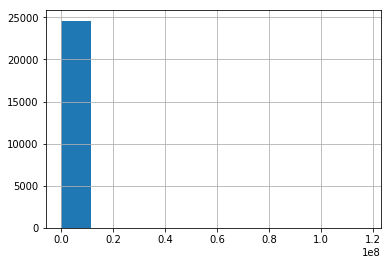

In [50]:
df.AMT_INCOME_TOTAL.hist()